In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

In [2]:
def map_sentiment(sentiment):
    if sentiment == 1:
        return 'positif'
    elif sentiment == 0:
        return 'netral'
    else:
        return 'negatif'

In [3]:
def prepare_datasets(corpus, labels, test_data_proportion=0.3, random_state=42):
    train_X, test_X, train_Y, test_Y = train_test_split(corpus, labels,
                                                        test_size=test_data_proportion,
                                                        random_state=random_state)
    return train_X, test_X, train_Y, test_Y

In [4]:
def tfidf_extractor(corpus, ngram_range=(1,2)):
    vectorizer = TfidfVectorizer(min_df=1,
                                norm='l2',
                                smooth_idf=True,
                                use_idf=True,
                                ngram_range=ngram_range)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features

In [5]:
df = pd.read_csv('sentiment_2000.csv')
df['sentimen'] = df['sentimen'].map(map_sentiment)
df.head(10)

,content,sentimen
0,capres mahfud md optimistis ppp parlemen tahun...,positif
1,cawapres koalisi perubahan muhaimin iskandar c...,positif
2,capres koalisi pdip ganjar pranowo khawatir su...,positif
3,capres ganjar pranowo mengaku khawatir preside...,positif
4,capres koalisi perubahan anies baswedan presid...,positif
5,capres koalisi perubahan anies baswedan mengak...,positif
6,cawapres koalisi indonesia maju kim gibran rak...,positif
7,capres koalisi perubahan anies baswedan menarg...,positif
8,capres koalisi indonesia maju prabowo subianto...,positif
9,capres koalisi perubahan anies baswedan mengun...,positif


In [6]:
# Split data
x_train, x_test, y_train, y_test = prepare_datasets(df['content'], df['sentimen'], test_data_proportion=0.3)

In [7]:
# Convert text labels to numerical labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Ensure the lengths match after splitting
y_train_encoded = y_train_encoded[:len(x_train)]
y_test_encoded = y_test_encoded[:len(x_test)]

In [8]:
# TF-IDF Vectorization
tfidf_vectorizer, tfidf_train_features = tfidf_extractor(x_train)
tfidf_test_features = tfidf_vectorizer.transform(x_test)

In [9]:
print("Shape of tfidf_train_features:", tfidf_train_features.shape)
print("Length of y_train_encoded:", len(y_train_encoded))

Shape of tfidf_train_features: (1400, 107361)
Length of y_train_encoded: 1400


In [10]:
print("Shape of tfidf_test_features:", tfidf_test_features.shape)
print("Length of y_test_encoded:", len(y_test_encoded))

Shape of tfidf_test_features: (600, 107361)
Length of y_test_encoded: 600


In [11]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, SpatialDropout1D
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

2024-04-14 18:45:21.534775: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-14 18:45:22.449665: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [12]:
# Tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

# Convert text to sequences of numbers
X_train_seq = tokenizer.texts_to_sequences(x_train)
X_test_seq = tokenizer.texts_to_sequences(x_test)

# Pad sequences to have the same length
max_length = max(len(seq) for seq in X_train_seq)
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length)

In [13]:
# Build LSTM model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=100))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(3, activation='softmax'))

2024-04-14 18:45:24.150286: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [14]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_padded, y_train_encoded, epochs=10, batch_size=64, validation_data=(X_test_padded, y_test_encoded))

# Evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test_encoded)
print("Accuracy:", accuracy)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 354ms/step - accuracy: 0.3456 - loss: 1.1565 - val_accuracy: 0.5367 - val_loss: 0.9811
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 414ms/step - accuracy: 0.5631 - loss: 0.9870 - val_accuracy: 0.6300 - val_loss: 0.9098
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 445ms/step - accuracy: 0.6797 - loss: 0.8620 - val_accuracy: 0.6150 - val_loss: 0.8701
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 448ms/step - accuracy: 0.7914 - loss: 0.6792 - val_accuracy: 0.6267 - val_loss: 0.8927
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 444ms/step - accuracy: 0.8307 - loss: 0.5013 - val_accuracy: 0.6533 - val_loss: 0.8926
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 452ms/step - accuracy: 0.9145 - loss: 0.3238 - val_accuracy: 0.6650 - val_loss: 0.9627
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 451ms/step - accuracy: 0.9336 - loss: 0.2507 - val_accuracy: 0.6500 - val_loss: 0.9939
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 447ms/step - accuracy: 0.9528 - loss: 0.2130 - val_accur

In [15]:
# Classification Report
predictions = np.argmax(model.predict(X_test_padded), axis=-1)
print(classification_report(y_test_encoded, predictions))

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step
              precision    recall  f1-score   support

           0       0.64      0.65      0.65       208
           1       0.70      0.74      0.72       186
           2       0.61      0.57      0.59       206

    accuracy                           0.65       600
   macro avg       0.65      0.65      0.65       600
weighted avg       0.65      0.65      0.65       600



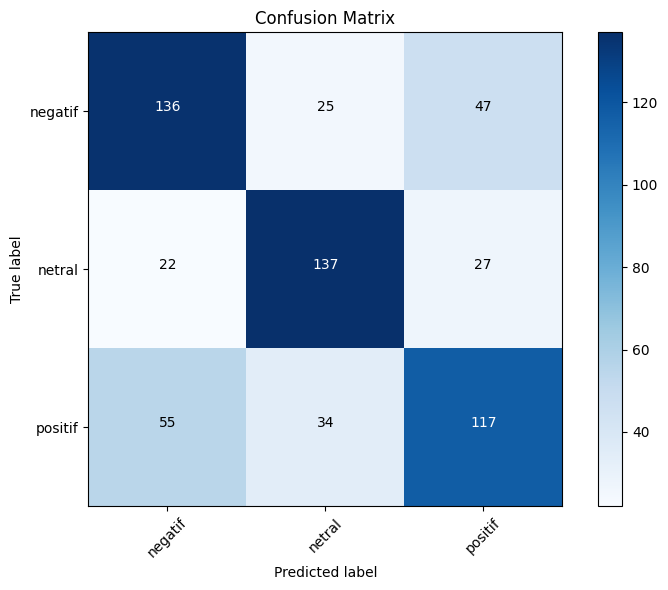

In [16]:
import itertools
# Confusion Matrix
cm = confusion_matrix(y_test_encoded, predictions)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
classes = label_encoder.classes_
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

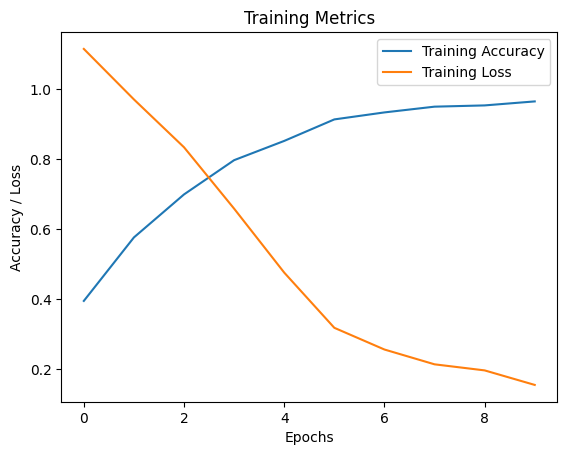

In [17]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.title('Training Metrics')
plt.legend()
plt.show()